# Time Series Forecasting with Transformer in PyTorch
This notebook demonstrates how to use a simple Transformer architecture for time series forecasting using PyTorch.

In [15]:
# Import required libraries
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from data_utils import generate_sine_wave, generate_complex_signal
from transformer_model import RecursiveTimeSeriesTransformer

In [16]:
# Hyperparameters
SEQ_LENGTH = 50
NUM_SAMPLES = 5000
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
FORECAST_STEPS = 10

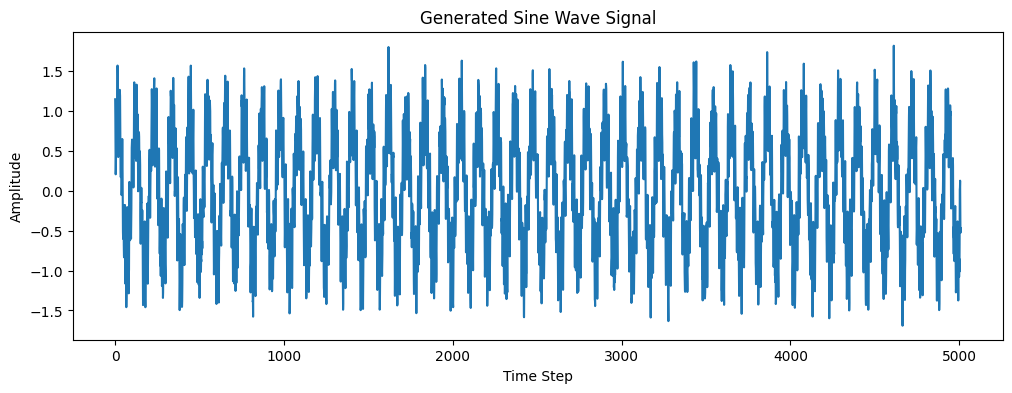

In [17]:
# Generate a single sine wave signal
signal = generate_complex_signal(NUM_SAMPLES + FORECAST_STEPS - 1)  # shape: (NUM_SAMPLES + FORECAST_STEPS - 1,)

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Generated Sine Wave Signal")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()

In [18]:
X = []
y = []
for i in range(len(signal) - SEQ_LENGTH - FORECAST_STEPS + 1):
    X.append(signal[i:i+SEQ_LENGTH])
    y.append(signal[i+SEQ_LENGTH:i+SEQ_LENGTH+FORECAST_STEPS])

X = np.array(X)
y = np.array(y)

In [19]:
# Normalize input and target data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# After training, inverse transform predictions for evaluation
def inverse_transform_predictions(preds):
    return scaler_y.inverse_transform(preds)

In [20]:
# Train/test split
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [21]:
# Convert to tensors and create DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Epoch 1/10, Loss: 1.088379
Epoch 2/10, Loss: 0.982870
Epoch 3/10, Loss: 0.767679
Epoch 4/10, Loss: 0.301740
Epoch 5/10, Loss: 0.125877
Epoch 6/10, Loss: 0.046477
Epoch 7/10, Loss: 0.036555
Epoch 8/10, Loss: 0.030557
Epoch 9/10, Loss: 0.031491
Epoch 10/10, Loss: 0.034223


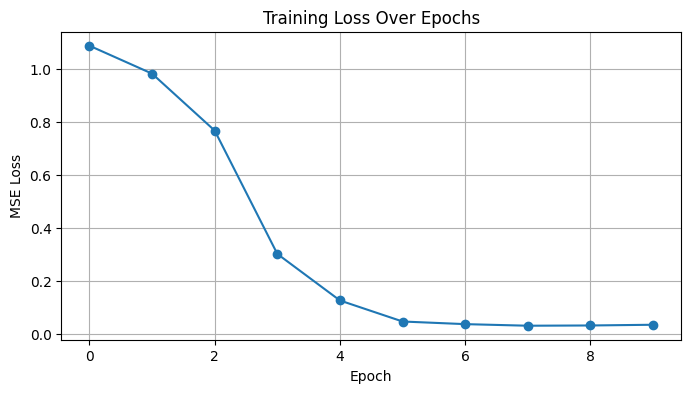

In [22]:
# Initialize the Recursive Transformer model
model = RecursiveTimeSeriesTransformer(seq_length=SEQ_LENGTH, forecast_steps=FORECAST_STEPS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
train_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [23]:
# # Training loop with teacher forcing
# train_losses = []
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     epoch_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         batch_X = batch_X.to(device)
#         batch_y = batch_y.to(device)
#         optimizer.zero_grad()
#         # Teacher forcing: feed ground truth for each step
#         output = torch.zeros_like(batch_y)
#         prev = batch_X[:, -1]  # last value in input sequence
#         for t in range(FORECAST_STEPS):
#             if t == 0:
#                 inp_seq = batch_X
#             else:
#                 # Concatenate previous ground truth value to sequence
#                 inp_seq = torch.cat([batch_X, batch_y[:, :t]], dim=1)
#                 inp_seq = inp_seq[:, -SEQ_LENGTH:]
#             out_step = model(inp_seq)[:, t].unsqueeze(1)
#             output[:, t] = out_step.squeeze(1)
#         loss = criterion(output, batch_y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * batch_X.size(0)
#     avg_loss = epoch_loss / len(train_loader.dataset)
#     train_losses.append(avg_loss)
#     print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# # Plot training loss
# plt.figure(figsize=(8, 4))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

Test Loss: 0.039273


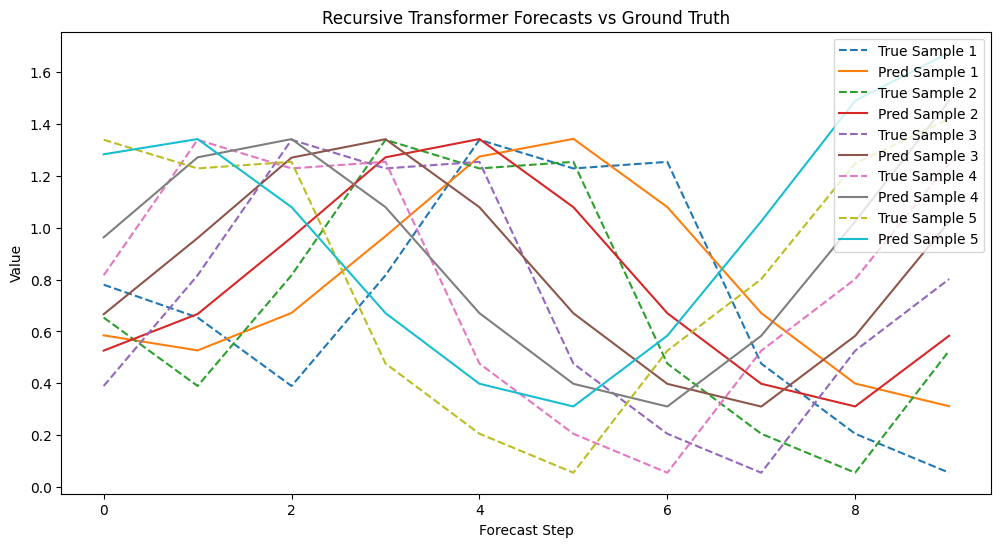

In [24]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.6f}")

# Concatenate all predictions and ground truth
predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

# Plot predictions vs ground truth for the first few samples
plt.figure(figsize=(12, 6))
for i in range(min(5, len(predictions))):
    plt.plot(range(FORECAST_STEPS), ground_truth[i], label=f'True Sample {i+1}', linestyle='--')
    plt.plot(range(FORECAST_STEPS), predictions[i], label=f'Pred Sample {i+1}')
plt.title('Recursive Transformer Forecasts vs Ground Truth')
plt.xlabel('Forecast Step')
plt.ylabel('Value')
plt.legend()
plt.show()